In [645]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from micrograd import Value
from renderer import draw_dot

In [646]:

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

# Verify that we can add values which get wrapped in Value nodes
z = Value(2.0)
2*z
z/a


Value(data=1.0)

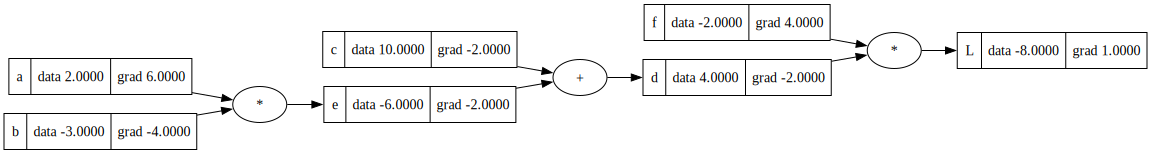

In [647]:
L.grad = 1.0
L.backward()
draw_dot(L)


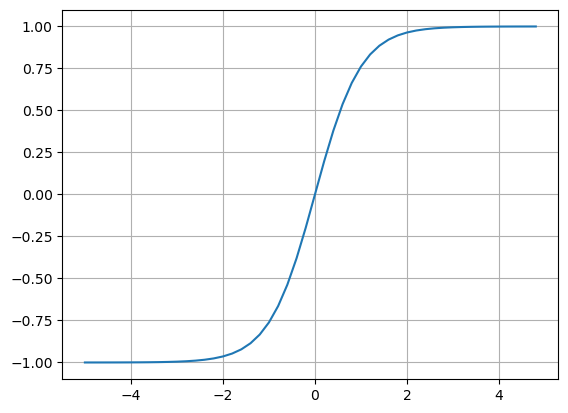

In [648]:
# Let's take a look at the tanh function
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2))); 
plt.grid()
plt.show()

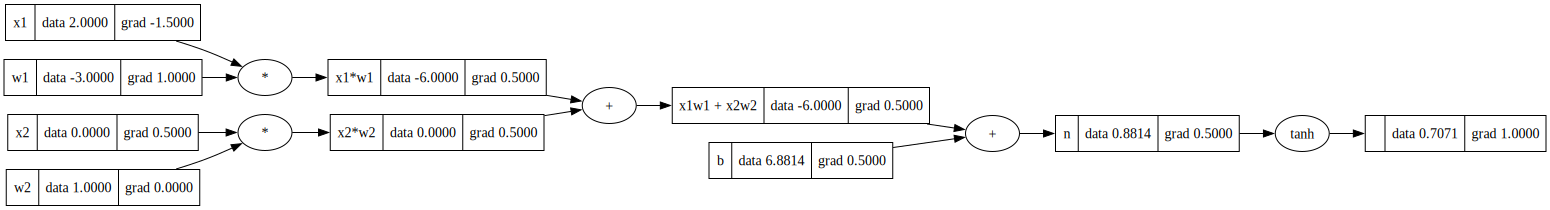

In [649]:
# Now we'll set up a simple neural layer.
# x1, x2 are inputs
# w1, w2 are the weights or "synaptic strengths" of the neuron
# b is the bias of the neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Carefully chosen bias to make the derivatives look nice :-)
b = Value(6.881373587, label='b')

# The reason these computations are broken down into small steps is to maintain
# pointers/references to each intermediate computation
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' 

# tanh is a hyperbolic function
o = n.tanh()
o.backward()

draw_dot(o)



In [650]:
# Now let's do the same thing, but using pytorch
import torch

t = torch.Tensor([[1,2,3],[4,5,6]])
t.shape
t.dtype # by default, torch.float32
t.double() # cast to torch.float64

x1 = torch.Tensor([2.0]).double()
x2 = torch.Tensor([0.0]).double()
w1 = torch.Tensor([-3.0]).double()
w2 = torch.Tensor([1.0]).double()
b = torch.Tensor([6.88137]).double()
for node in [x1, x2, w1, w2, b]:
    node.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print ('x1 grad:', x1.grad.item())
print(o.item())



0.7071050214706146
x1 grad: -1.500007465833125
0.7071050214706146


In [651]:
import random

class Neuron:
    def __init__(self, nin): # nin is "number of inputs"
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        # Mirrors the API of PyTorch
        return self.w + [self.b]

# A Layer here is simply a list of neurons
# nout is # of neurons in a single layer
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params


class MLP:
    # Multi-layer perceptron

    def __init__(self, nin, nouts):
        # nouts is a list
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [652]:
x = [2., 3., -1.]
n = MLP(3, [4,4,1])
n(x)
len(n.parameters())


41

<class 'micrograd.Value'>


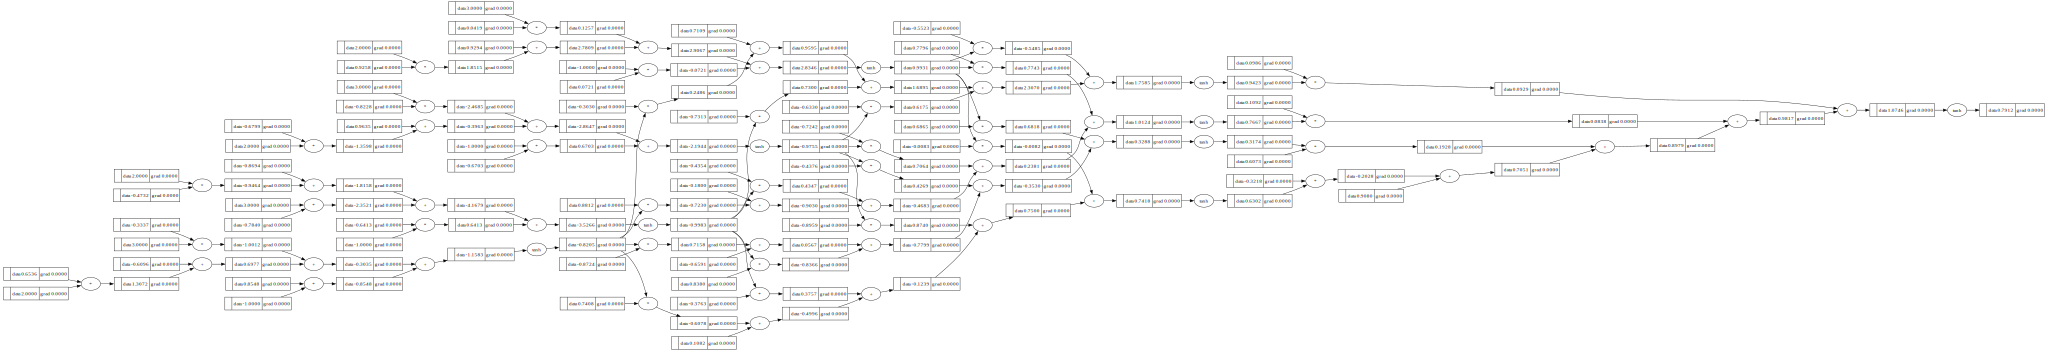

In [653]:
print(type(n(x)))
draw_dot(n(x))

In [654]:
# Simple example of a dataset
xs = [
    [2.,3.,-1.],
    [3.,-1.,0.5],
    [0.5,1.,1.],
    [1.,1.,-1.],
]

# desired targets for each input vector in xs (values are {1,-1} so this is like a binary classifier)
ys = [1., -1., -1., 1.]
ypred = [n(x) for x in xs]
print(ypred)

# These predictions are not good. So first we write a loss function to measure how well it performs.
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss.backward()

[Value(data=0.7911875606936976), Value(data=0.24539917491650506), Value(data=0.40516285413077663), Value(data=0.7702654166066574)]


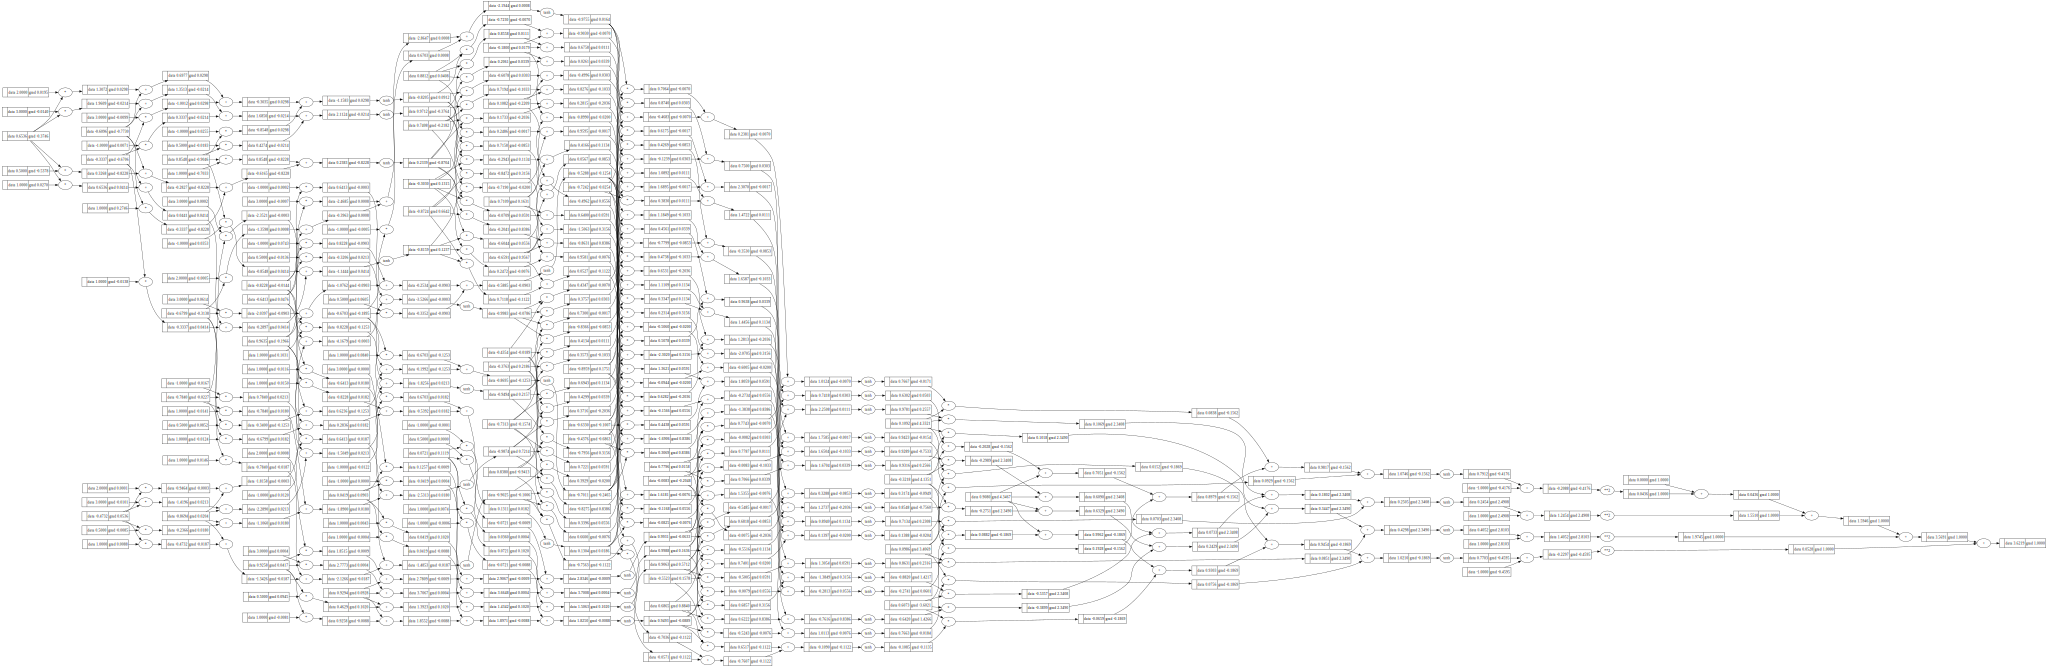

In [655]:
draw_dot(loss)

In [ ]:
for k in range(200):
    # Forward pass:
    ypred = [n(x) for x in xs]
    # in reality we might not use MSE but rather cross-entropy loss
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # Backward pass:
    for p in n.parameters():
        p.grad = 0
    loss.backward()

    # update / grad descent
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)


0 3.621882365127622
1 3.1779989391739667
2 3.6769256492388274
3 0.14376166172216467
4 0.10103188031368622
5 0.07988364020509267
6 0.06575046990270315
7 0.05563312804185708
8 0.048062168347633216
9 0.04220340905873662
10 0.037547245116795205
11 0.03376561431426734
12 0.03063837190580614
13 0.028012646222437206
14 0.025779175131477497
15 0.023857916171764564
16 0.022188968352620617
17 0.0207266608729375
18 0.019435596407802853
19 0.018287937669395037
20 0.017261506124000615
21 0.016338423943446402
22 0.01550412709292429
23 0.01474663686099421
24 0.014056014491197899
25 0.013423947591267756
26 0.012843432752560936
27 0.012308529342281705
28 0.011814166587988085
29 0.011355991014461922
30 0.0109302447528895
31 0.010533667697618727
32 0.010163418249807928
33 0.009817008669307912
34 0.009492251997867488
35 0.009187218215506514
36 0.008900197815244168
37 0.00862967137681524
38 0.008374284021296002
39 0.008132823859917886
40 0.007904203729319053
41 0.007687445644904691
42 0.007481667513316537


In [657]:
ypred

[Value(data=0.9799881335632336),
 Value(data=-0.9824975888844945),
 Value(data=-0.9771891656155582),
 Value(data=0.9903817525790226)]